# Laplace approximatio using KFAC approximation to posterior

Based on
https://patel-zeel.github.io/blog/posts/2022-10-18-kfac-laplace.html


# Setup

In [24]:

import numpy as np
import jax.numpy as jnp
import kfac_jax
from jax import random as jr
import haiku as hk

from math import prod
from functools import partial
from time import time

import blackjax
import flax.linen as nn
import jax
from jax.flatten_util import ravel_pytree
import jax.tree_util as jtu
import jax.numpy as jnp
# jnp.set_printoptions(linewidth=2000)

import optax
from tqdm import trange

import arviz as az
import seaborn as sns

import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", False)

#%reload_ext watermark


In [3]:
jitter = 1e-6

def get_shapes(params):
    return jtu.tree_map(lambda x:x.shape, params)

def svd_inverse(matrix):
    U, S, V = jnp.linalg.svd(matrix+jnp.eye(matrix.shape[0])*jitter)
    
    return V.T/S@U.T

# Data

In [4]:
# 2d XOR

X = jnp.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = jnp.array([0, 1, 1, 0])

X.shape, y.shape

((4, 2), (4,))

# Model

In [5]:
class MLP(nn.Module):
    features: []

    @nn.compact
    def __call__(self, x):
        for n_features in self.features[:-1]:
            x = nn.Dense(n_features, kernel_init=jax.nn.initializers.glorot_normal(), bias_init=jax.nn.initializers.normal())(x)
            x = nn.relu(x)
        
        x = nn.Dense(features[-1])(x)
        return x.ravel()

In [6]:
features = [2, 1]
key = jax.random.PRNGKey(0)

model = MLP(features)
params = model.init(key, X).unfreeze()

get_shapes(params)

{'params': {'Dense_0': {'bias': (2,), 'kernel': (2, 2)},
  'Dense_1': {'bias': (1,), 'kernel': (2, 1)}}}

In [7]:
N = X.shape[0]
logits = model.apply(params, X)
print(logits)
assert logits.shape[0] == N


[ 0.00687164 -0.01380461  0.          0.        ]


# MAP estimation

In [8]:
noise_var = 0.1

def neg_log_joint(params):
    y_pred = model.apply(params, X)
    flat_params = ravel_pytree(params)[0]
    log_prior = jax.scipy.stats.norm.logpdf(flat_params).sum()
    log_likelihood = jax.scipy.stats.norm.logpdf(y, loc=y_pred, scale=noise_var).sum()
    
    return -(log_prior + log_likelihood)

print(neg_log_joint(params))

105.03511


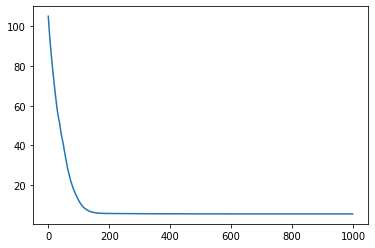

In [9]:
key = jax.random.PRNGKey(0)
params = model.init(key, X).unfreeze()
n_iters = 1000

value_and_grad_fn = jax.jit(jax.value_and_grad(neg_log_joint))
opt = optax.adam(0.01)
state = opt.init(params)

def one_step(params_and_state, xs):
    params, state = params_and_state
    loss, grads = value_and_grad_fn(params)
    updates, state = opt.update(grads, state)
    params = optax.apply_updates(params, updates)
    return (params, state), loss
    
(params, state), losses = jax.lax.scan(one_step, init=(params, state), xs=None, length=n_iters)

plt.plot(losses);

In [35]:

jnp.set_printoptions(precision=4)

print(params)

flat_params, unravel_fn = ravel_pytree(params)
display(flat_params)
#print(['{:0.4f}'.format(x) for x in flat_params])
print(len(flat_params))

# get parameters for each leaf as list of matrices
flat_params, tree_def = jtu.tree_flatten(params)
display(flat_params)
#print(['{:0.4f}'.format(x) for x in flat_params])
print(len(flat_params))

# get parameters for each leaf as list of dictionary
is_leaf = lambda param: 'bias' in param
layers, tree_def = jtu.tree_flatten(params, is_leaf=is_leaf)
print(layers)
print(len(layers))
print(layers[0])
print(layers[1])

{'params': {'Dense_0': {'bias': Array([-0.0002,  0.0003], dtype=float32), 'kernel': Array([[ 0.8275, -0.8315],
       [-0.8277,  0.8325]], dtype=float32)}, 'Dense_1': {'bias': Array([0.0135], dtype=float32), 'kernel': Array([[1.1751],
       [1.1685]], dtype=float32)}}}


Array([-2.4913e-04,  2.7019e-04,  8.2753e-01, -8.3148e-01, -8.2766e-01,
        8.3254e-01,  1.3518e-02,  1.1751e+00,  1.1685e+00], dtype=float32)

9


[Array([-0.0002,  0.0003], dtype=float32),
 Array([[ 0.8275, -0.8315],
        [-0.8277,  0.8325]], dtype=float32),
 Array([0.0135], dtype=float32),
 Array([[1.1751],
        [1.1685]], dtype=float32)]

4
[{'bias': Array([-0.0002,  0.0003], dtype=float32), 'kernel': Array([[ 0.8275, -0.8315],
       [-0.8277,  0.8325]], dtype=float32)}, {'bias': Array([0.0135], dtype=float32), 'kernel': Array([[1.1751],
       [1.1685]], dtype=float32)}]
2
{'bias': Array([-0.0002,  0.0003], dtype=float32), 'kernel': Array([[ 0.8275, -0.8315],
       [-0.8277,  0.8325]], dtype=float32)}
{'bias': Array([0.0135], dtype=float32), 'kernel': Array([[1.1751],
       [1.1685]], dtype=float32)}


# Plugin prediction

In [17]:
y_map = model.apply(params, X)
y_map

Array([0.01383345, 0.98666817, 0.98563665, 0.01507111], dtype=float32)

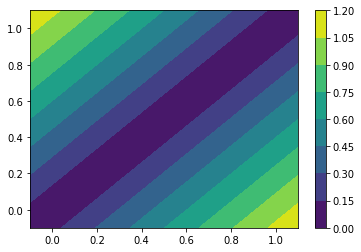

In [18]:
x = jnp.linspace(-0.1,1.1,100)
X1, X2 = jnp.meshgrid(x, x)

def predict_fn(x1, x2):
    return model.apply(params, jnp.array([x1,x2]).reshape(1,2))

predict_fn_vec = jax.jit(jax.vmap(jax.vmap(predict_fn)))

Z = predict_fn_vec(X1, X2).squeeze()

plt.contourf(X1, X2, Z)
plt.colorbar();

# Full Hessian Laplace

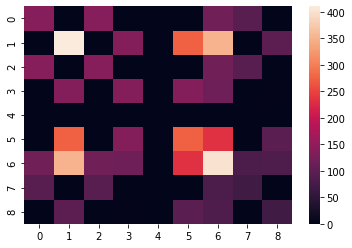

In [13]:
flat_params, unravel_fn = ravel_pytree(params)

def neg_log_joint_flat(flat_params):
    return neg_log_joint(unravel_fn(flat_params))

H = jax.hessian(neg_log_joint_flat)(flat_params)

sns.heatmap(H);

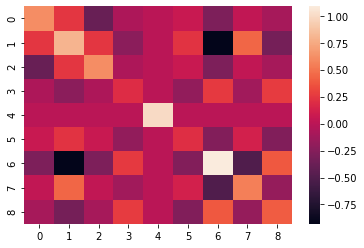

In [14]:
posterior_cov = svd_inverse(H)

sns.heatmap(posterior_cov);

In [15]:
class FullHessianLaplace:
    def __init__(self, map_params, model):
        flat_params, self.unravel_fn = ravel_pytree(map_params)

        def neg_log_joint_flat(flat_params):
            params = unravel_fn(flat_params)
            return neg_log_joint(params)

        self.H = jax.hessian(neg_log_joint_flat)(flat_params)
        
        self.mean = flat_params
        self.cov = svd_inverse(self.H)
        self.model = model

    def _vectorize(self, f, seed, shape, f_kwargs={}):
        length = prod(shape)
        seeds = jax.random.split(seed, num=length).reshape(shape+(2,))
        
        sample_fn = partial(f, **f_kwargs)
        for _ in shape:
            sample_fn = jax.vmap(sample_fn)
        
        return sample_fn(seed=seeds)
    
    def _sample(self, seed):
        sample = jax.random.multivariate_normal(seed, mean=self.mean, cov=self.cov)
        return self.unravel_fn(sample)
    
    def sample(self, seed, shape):
        return self._vectorize(self._sample, seed, shape)
    
    def _predict(self, X, seed):
        sample = self._sample(seed)
        return self.model.apply(sample, X)
    
    def predict(self, X, seed, shape):
        return self._vectorize(self._predict, seed, shape, {'X': X})

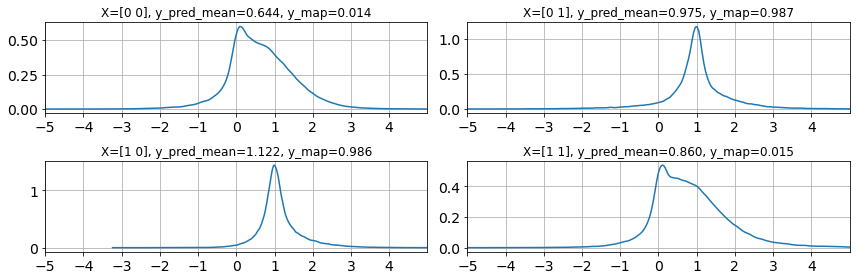

In [19]:
posterior = FullHessianLaplace(params, model)

seed = jax.random.PRNGKey(1)
n_samples = 100000
y_pred_full = posterior.predict(X, seed=seed, shape=(n_samples,))
ulim = 5
llim = -5

fig, ax = plt.subplots(2,2,figsize=(12,4))
ax=ax.ravel()
for i in range(len(y)):
    az.plot_dist(y_pred_full[:, i], ax=ax[i]);
    ax[i].grid(True)
    ax[i].set_xticks(range(llim,ulim))
    ax[i].set_xlim(llim, ulim)
    ax[i].set_title(f"X={X[i]}, y_pred_mean={y_pred_full[:, i].mean():.3f}, y_map={y_map[i]:.3f}")
fig.tight_layout()

# Block diagonal approximation

In [20]:
flat_params, tree_def = jtu.tree_flatten(params)
display(flat_params, tree_def)

[Array([-0.00024913,  0.00027019], dtype=float32),
 Array([[ 0.8275324 , -0.8314813 ],
        [-0.8276633 ,  0.83254045]], dtype=float32),
 Array([0.01351773], dtype=float32),
 Array([[1.1750739],
        [1.1685134]], dtype=float32)]

PyTreeDef({'params': {'Dense_0': {'bias': *, 'kernel': *}, 'Dense_1': {'bias': *, 'kernel': *}}})

In [36]:
is_leaf = lambda param: 'bias' in param
layers, tree_def = jtu.tree_flatten(params, is_leaf=is_leaf)
display(layers, tree_def)

[{'bias': Array([-0.0002,  0.0003], dtype=float32),
  'kernel': Array([[ 0.8275, -0.8315],
         [-0.8277,  0.8325]], dtype=float32)},
 {'bias': Array([0.0135], dtype=float32),
  'kernel': Array([[1.1751],
         [1.1685]], dtype=float32)}]

PyTreeDef({'params': {'Dense_0': *, 'Dense_1': *}})

In [37]:
flat_params = list(map(lambda x: ravel_pytree(x)[0], layers))
unravel_fn_list = list(map(lambda x: ravel_pytree(x)[1], layers))
display(flat_params, unravel_fn_list)

[Array([-2.4913e-04,  2.7019e-04,  8.2753e-01, -8.3148e-01, -8.2766e-01,
         8.3254e-01], dtype=float32),
 Array([0.0135, 1.1751, 1.1685], dtype=float32)]

In [38]:
def modified_neg_log_joint_fn(flat_params):
    layers = jtu.tree_map(lambda unravel_fn, flat_param: unravel_fn(flat_param), unravel_fn_list, flat_params)
    params = tree_def.unflatten(layers)
    return neg_log_joint(params)

full_hessian = jax.hessian(modified_neg_log_joint_fn)(flat_params)

# Pick diagonal entries from the Hessian
useful_hessians = [full_hessian[i][i] for i in range(len(full_hessian))]
useful_hessians

[Array([[139.0798,   0.    , 138.0798,   0.    ,   0.    ,   0.    ],
        [  0.    , 410.6271,   0.    , 136.5424,   0.    , 273.0847],
        [138.0798,   0.    , 139.0798,   0.    ,   0.    ,   0.    ],
        [  0.    , 136.5424,   0.    , 137.5424,   0.    , 136.5424],
        [  0.    ,   0.    ,   0.    ,   0.    ,   1.    ,   0.    ],
        [  0.    , 273.0847,   0.    , 136.5424,   0.    , 274.0847]],      dtype=float32),
 Array([[401.    ,  82.7283,  83.441 ],
        [ 82.7283,  69.4398,   0.    ],
        [ 83.441 ,   0.    ,  70.3575]], dtype=float32)]

In [39]:
class KFACHessianLaplace:
    def __init__(self, map_params, model):
        self.model = model
        layers, self.tree_def = jtu.tree_flatten(map_params, is_leaf=lambda x: 'bias' in x)
        flat_layers = [ravel_pytree(layer) for layer in layers]
        self.means = list(map(lambda x: x[0], flat_layers))
        self.unravel_fn_list = list(map(lambda x: x[1], flat_layers))

        def neg_log_joint_flat(flat_params):
            flat_layers = [self.unravel_fn_list[i](flat_params[i]) for i in range(len(flat_params))]
            params = self.tree_def.unflatten(flat_layers)
            return neg_log_joint(params)

        self.H = jax.hessian(neg_log_joint_flat)(self.means)
        self.useful_H = [self.H[i][i] for i in range(len(self.H))]
        
        self.covs = [svd_inverse(matrix) for matrix in self.useful_H]
        
    def _vectorize(self, f, seed, shape, f_kwargs={}):
        length = prod(shape)
        seeds = jax.random.split(seed, num=length).reshape(shape+(2,))
        
        sample_fn = partial(f, **f_kwargs)
        for _ in shape:
            sample_fn = jax.vmap(sample_fn)
        
        return sample_fn(seed=seeds)
    
    def _sample_partial(self, seed, unravel_fn, mean, cov):
        sample = jax.random.multivariate_normal(seed, mean=mean, cov=cov)
        return unravel_fn(sample)
    
    def _sample(self, seed):
        seeds = [seed for seed in jax.random.split(seed, num=len(self.means))]
        flat_sample = jtu.tree_map(self._sample_partial, seeds, self.unravel_fn_list, self.means, self.covs)
        sample = self.tree_def.unflatten(flat_sample)
        return sample
    
    def sample(self, seed, n_samples=1):
        return self._vectorize(self._sample, seed, shape)
    
    def _predict(self, X, seed):
        sample = self._sample(seed)
        return self.model.apply(sample, X)
    
    def predict(self, X, seed, shape):
        return self._vectorize(self._predict, seed, shape, {'X': X})

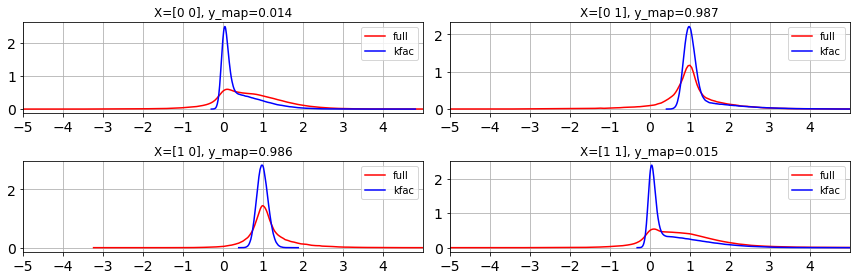

In [40]:
kfac_posterior = KFACHessianLaplace(params, model)

seed = jax.random.PRNGKey(1)
n_samples = 1000000
y_pred_kfac = kfac_posterior.predict(X, seed=seed, shape=(n_samples, ))
ulim = 5
llim = -5

fig, ax = plt.subplots(2,2,figsize=(12,4))
ax=ax.ravel()
for i in range(len(y)):
    az.plot_dist(y_pred_full[:, i], ax=ax[i], label='full', color='r')
    az.plot_dist(y_pred_kfac[:, i], ax=ax[i], label='kfac', color='b')
    ax[i].grid(True)
    ax[i].set_xticks(range(llim,ulim))
    ax[i].set_xlim(llim, ulim)
    ax[i].set_title(f"X={X[i]}, y_map={y_map[i]:.3f}")
fig.tight_layout()

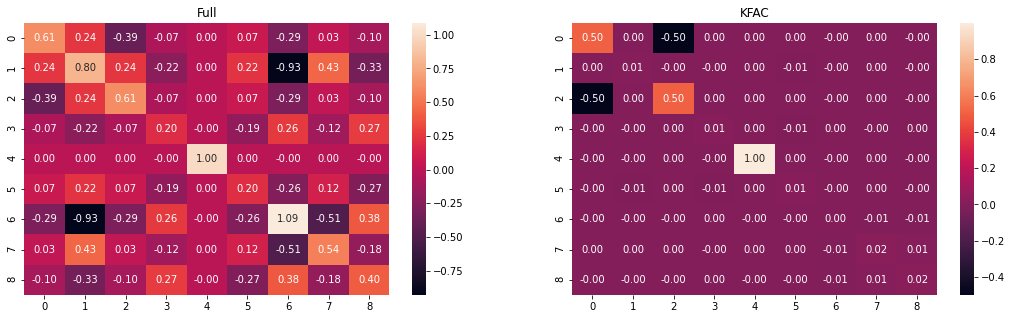

In [41]:
fig, ax = plt.subplots(1,2,figsize=(18,5))
sns.heatmap(posterior.cov, ax=ax[0], annot=True, fmt = '.2f')
ax[0].set_title('Full')

kfac_cov = posterior.cov * 0
offset = 0
for cov in kfac_posterior.covs:
    length = cov.shape[0]
    kfac_cov = kfac_cov.at[offset:offset+length, offset:offset+length].set(cov)
    offset += length

sns.heatmap(kfac_cov, ax=ax[1], annot=True, fmt = '.2f')
ax[1].set_title('KFAC');

# Use KFAC-JAX library

In [ ]:
flat_params, unravel_fn = ravel_pytree(params)

def neg_log_joint_flat(flat_params):
    return neg_log_joint(unravel_fn(flat_params))

H = jax.hessian(neg_log_joint_flat)(flat_params)

sns.heatmap(H);

In [42]:
noise_var = 0.1

def neg_log_joint(params):
    y_pred = model.apply(params, X)
    flat_params = ravel_pytree(params)[0]
    log_prior = jax.scipy.stats.norm.logpdf(flat_params).sum()
    log_likelihood = jax.scipy.stats.norm.logpdf(y, loc=y_pred, scale=noise_var).sum()
    
    return -(log_prior + log_likelihood)

print(params)
print(neg_log_joint(params))

{'params': {'Dense_0': {'bias': Array([-0.0002,  0.0003], dtype=float32), 'kernel': Array([[ 0.8275, -0.8315],
       [-0.8277,  0.8325]], dtype=float32)}, 'Dense_1': {'bias': Array([0.0135], dtype=float32), 'kernel': Array([[1.1751],
       [1.1685]], dtype=float32)}}}
5.526351


In [45]:
def loss_fn(params, batch):
  del batch
  y_pred = model.apply(params, X)
  flat_params = ravel_pytree(params)[0]
  log_prior = jax.scipy.stats.norm.logpdf(flat_params).sum()
  log_likelihood = jax.scipy.stats.norm.logpdf(y, loc=y_pred, scale=noise_var).sum()
  kfac_jax.register_squared_error_loss(y_pred, y)
  return -(log_likelihood + log_prior)


print(loss_fn(params, None))

5.526351


In [51]:
estimator = kfac_jax.ExplicitExactCurvature(loss_fn)
print(type(estimator), estimator)
estimator = estimator.update_curvature_matrix_estimate(estimator, ema_old=0, ema_new=1, batch_size=0, rng=jax.random.PRNGKey(0), 
                                                       func_args=None, pmap_axis_name=None, estimation_mode='fisher_gradients')
print(type(estimator), estimator)


<class 'kfac_jax._src.curvature_estimator.ExplicitExactCurvature'> <kfac_jax._src.curvature_estimator.ExplicitExactCurvature object at 0x7f838d5c6d90>


TypeError: Value <kfac_jax._src.curvature_estimator.ExplicitExactCurvature object at 0x7f838d5c6d90> with type <class 'kfac_jax._src.curvature_estimator.ExplicitExactCurvature'> is not a valid JAX type